# Quantum Black Holes (Group 4) - Quantum Corrections
(Suzanne Parr)

In astronomy the only thing we can detect is light. Understanding how it behaves near massive objects is essential to our understanding of black holes as a known form of "dark matter". 

The research goal is to understand how quantum effects can cause slight alterations to the path of massless particles like light - and also massive particles - in the vicinity of black holes. We start with the Schwarzschild metric which describes particle motion in a spacetime governed by general relativity. This metric predicts orbital precession (observed in the orbit of planet Mercury), light deflection (lensing), and time dilation for a particle moving near a massive object. 

Here we add quantum corrections to our Schwarzschild black hole model. The corrections are derived in a paper by Saeed Rastgoo and colleagues. Past researchers found they could weave uncertainty-inspired quantum physics in a Schwarzschild black hole and the interior would behave according to observation but the math breaks down where spacetime flattens i.e. in the asymptotic region. To rectify this the team borrows an idea from 'Loop Quantum Gravity', namely that quantum parameters (QM) are momentum-dependent. This leads to an improvement to the interior model, which also works when extrapolated out to a full spacetime.

In [144]:
# import code libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sp
import OGRePy as gr
from OGRePy.abc import t, r, theta, phi, E, M, L, lamda, sigma, epsilon
from IPython.display import display, Math

# Define parameters symbolically

Define all parameters as symbolic variables to enable their use in both symbolic expressions and numerical calculations.

In [145]:
# Define symbolic variables
t = gr.sym('t')
r = gr.sym('r', nonnegative=True)
theta = gr.sym('theta')
phi = gr.sym('phi')
lamda = gr.sym('lamda')
sigma = gr.sym('sigma')
epsilon = gr.sym('epsilon')
E = gr.sym('E')
M = gr.sym('M')
L = gr.sym('L')
Q_b = gr.sym('Q_b')
Q_c = gr.sym('Q_c')
v_eff = gr.sym('v_eff')
r_sc = gr.sym('r_sc')

# symbol test
diff_expr = gr.s.diff(Q_b**2 + Q_c, Q_b)
display(Math(sp.latex(diff_expr)))


<IPython.core.display.Math object>

# Schwarzschild Metric Tensor

The Schwarzschild metric is a 3 x 3 matrix. In order to visualize it we've rendered it using symbols.

In [3]:
# Block 1 - display metric tensor - use OGRePy

def build_metric():
    # define symbolic variables for t, r, theta, phi
    spher_coords = gr.Coordinates(t, r, theta, phi)
    
    # define metric functions symbolically
    f = gr.func('f')('r')
    g = gr.func('g')('r')
    h = gr.func('h')('r')

    the_metric = gr.Metric(coords=spher_coords, components=gr.diag(-f, g, h, h * gr.s.sin(theta)**2))

    return the_metric, spher_coords

# build the symbolic metric
metric_sym, coords1 = build_metric()

metric_sym.show()
coords1.show()


$$g{}_{\mu}{}_{\nu}\Bigg|_{\left(t, r, \theta, \phi\right)} = \left(\begin{matrix}- f{\left(r \right)} & 0 & 0 & 0\\0 & g{\left(r \right)} & 0 & 0\\0 & 0 & h{\left(r \right)} & 0\\0 & 0 & 0 & h{\left(r \right)} \sin^{2}{\left(\theta \right)}\end{matrix}\right)$$

$$\left(\begin{matrix}t & r & \theta & \phi\end{matrix}\right)$$

# Improved Metric with Quantum Corrections

The following code defines functions that derive from the improved metric: a quantum-corrected variation of the Schwarzschild (SC) metric. Like the classical SC metric,

$$ ds^2 = - f(r) \, dt^2 + g(r) \, dr^2 + h(r) \left( d\theta^2 + \sin^2\theta \, d\phi^2 \right) $$

the improved metric represents a static, spherically symmetric spacetime. Due to spherical symmetry we can confine the direction of angular momentum to $\theta = \frac{\pi}{2}$ and the conserved magnitude to $L = h(r) \frac{d\phi}{d\lambda}$. Since the metric is independent of 't' we can write the conserved energy as, $E = -f(r) \frac{dt}{d\lambda}$. As with the SC metric we can integrate once to get expressions for $\dot{t}$, $\dot{r}^2$ and $\dot{\phi}$ in terms of the metric functions, the conserved quantities, E and L and $\epsilon$ (0 for null and 1 for time-like geodesics). If we re-arrange the radial component to isolate $E^2$ we can "read off" the Effective Potential,

$$V_{\text{eff}}(r) = - \frac{1}{2} f(r) \left( \frac{L^2}{h(r)} + \epsilon \right)$$

an expression that is comparable to Newtonian gravitational potential energy. Below we define the metric functions, Effective Potential, and Equations of Motion for the quantum-corrected metric. We also get a new version of $\frac{dr}{d\lambda}$, 

$$\frac{dr}{d\lambda} = \left( \frac{-1}{g(r)} \left( \frac{E^2}{f(r)} + \left( \frac{L^2}{h(r)} + \epsilon \right) \right) \right)^{\frac{1}{2}}$$


In [146]:
# block 2 - functions: Schwarzschild radius, quantum-corrected metric functions, effective potential and equations of motion.

# constants: normalized speed of light & gravitational constant
c = 1.0 
G = 1.0 

# get schwarzschild radius from mass
def r_sc(M):
    return (2*G*M/c**2)

# schwarzschild metric functions (dependent on radial coordinate, r, SC radius and quantum corrections, Q_b, Q_c)
def f(r, M, Q_b, Q_c):
    return -(1 + Q_b/r**2) * (1 + (Q_c*(2*M)**2)/(4*r**8))**(-1/4) * (1-(2*M)/(gr.s.sqrt(r**2+Q_b)))

def g(r, M, Q_b, Q_c):
    return (1 + (Q_c*(2*M)**2)/(4*r**8))**(1/4) * (1-(2*M)/(gr.s.sqrt(r**2+Q_b)))**(-1)

def h(r, M, Q_c):
    return r**2 * (1 + (Q_c*(2*M)**2)/(4*r**8))**(1/4)

# effective potential
def v_eff(r, M, L, Q_b, Q_c, epsilon=0):
    return -0.5*f(r, M, Q_b, Q_c) * (L**2*h(r, M, Q_c)**(-1) + epsilon)

# lamda - not accessed in this function - can be replaced by tau for massive particles
def eq_of_motion(lamda, y, params, epsilon=0):

    t, r, phi = y
    E, L, M, Q_b, Q_c = params

    dt_dlamda = - E / f(r, M, Q_b, Q_c)
    dphi_dlamda = L / h(r, M, Q_c)
    # **** (+) if going away from BH; (-) if going towards the BH ****
    dr_dlamda = gr.s.sqrt(-g(r, M, Q_b, Q_c)**(-1) * (E**2 / f(r, M, Q_b, Q_c) + (L**2 / h(r, M, Q_c) + epsilon)))
    # dr_dlamda = -gr.s.sqrt(-g(r, M, Q_b, Q_c)**(-1) * (E**2 / f(r, M, Q_b, Q_c) + (L**2 / h(r, M, Q_c) + epsilon)))

    return [dt_dlamda, dr_dlamda, dphi_dlamda]

# symbols test
display(Math(r"v_{eff} (\epsilon = 0) = " + sp.latex(v_eff(r, M, L, Q_b, Q_c))))

<IPython.core.display.Math object>

# Assign Values to Constants

Assign values for Mass (central massive object), Energy and Angular momentum of the orbiting particle, and a set of values for the quantum parameters (QM) to see how quantum effects change effective potential.

In [147]:
# block 3 - assign values for mass, energy, and angular momentum
M1 = 1.0  
rs1 = r_sc(M1)
r1 = 10 * rs1
Q_b0 = 0.0
Q_b1 = 0.25
Q_b2 = 0.5
Q_b3 = 0.75
Q_c0 = 0.0
Q_c1 = 0.25
Q_c2 = 0.5
Q_c3 = 0.75

# conserved quantities (constants); values used to study effective potential
E1 = 1.0 # energy of orbiting particle
L1 = 4.3 # angular momentum of orbiting particle

# light orbit parameters
# circular orbit at maxima at r = 3M
r2 = 3 * M1
L2 = np.sqrt(27) * E1 * M1

# orbits starting at infinity
r3 = 10 * rs1
L3 = np.sqrt(27) * E1 * M1 + 0.4 # scattering
L4 = np.sqrt(27) * E1 * M1 - 0.4 # plunging

# orbits that begin between 2M and 3M
r4 = 2.2 * M1
L5 = E1 / np.sqrt(0.022) # plunges
L6 = E1 / np.sqrt(0.032) # plunges
L7 = E1 / np.sqrt(0.042) # escapes

print(L2)
print(L3, L4)
print(L5, L6, L7)

# calculate and print SC metric components at a given radian distance from the BH and BH mass.
f1 = f(r1, M1, Q_b1, Q_c1)
g1 = g(r1, M1, Q_b1, Q_c1)
h1 = h(r1, M1, Q_c1)

print(f"f(r) = {f1}")
print(f"g(r) = {g1}")
print(f"h(r) = {h1}")

5.196152422706632
5.596152422706632 4.796152422706632
6.741998624632421 5.5901699437494745 4.879500364742666
f(r) = -0.900593754879089
g(r) = 1.11107255028028
h(r) = 400.00000000097657


# Effective Potential as a function of radius from the black hole

Next we explore the effective potential. To have orbits (around a massive object) we need either a maxima or a minima. Minima produce very stable orbits. Maxima can sustain an orbit but the object is easily knocked out of this orbit. If we plot $V_{\text{eff}}(r)$, constrain M and L and vary the quantum parameters (QM) we find that the extremum (maximum) is always at 3*M when QM = 0 and move to the left as QM increase from 0 to 1.

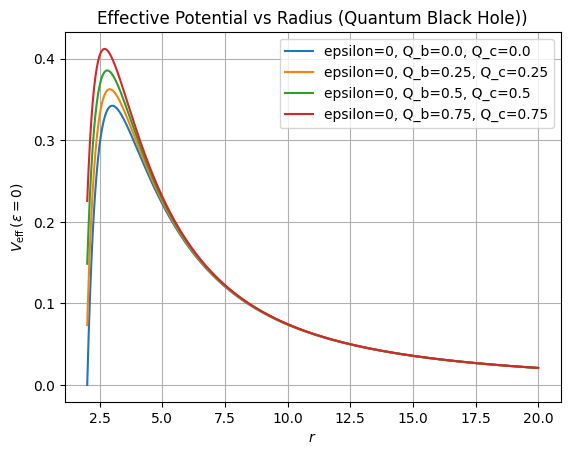

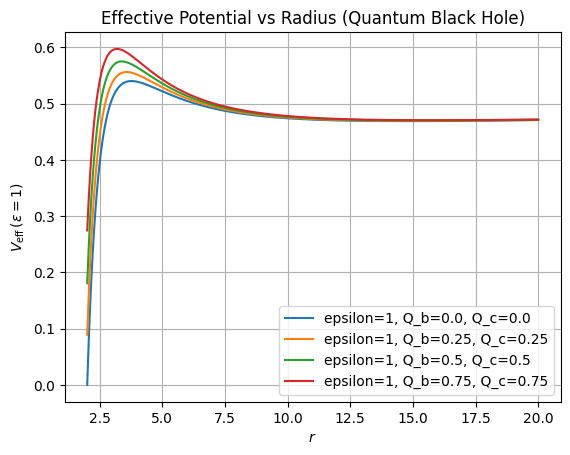

In [148]:
# block 4 - calculate v_eff as a function of r given M (black hole mass), L (particles's angular momentum)
# span of r values
r_vals = np.linspace(rs1, r1, 1000)

# get list of effective potential values for sigma=0
v_eff_vals_Q0 = np.array([v_eff(i, M1, L1, Q_b0, Q_c0, epsilon=0) for i in r_vals])
v_eff_vals_Q1 = np.array([v_eff(i, M1, L1, Q_b1, Q_c1, epsilon=0) for i in r_vals])
v_eff_vals_Q2 = np.array([v_eff(i, M1, L1, Q_b2, Q_c2, epsilon=0) for i in r_vals])
v_eff_vals_Q3 = np.array([v_eff(i, M1, L1, Q_b3, Q_c3, epsilon=0) for i in r_vals])

# get list of effective potential values for sigma=1
v_eff_vals_Q0_1 = np.array([v_eff(i, M1, L1, Q_b0, Q_c0, epsilon=1) for i in r_vals])
v_eff_vals_Q1_1 = np.array([v_eff(i, M1, L1, Q_b1, Q_c1, epsilon=1) for i in r_vals])
v_eff_vals_Q2_1 = np.array([v_eff(i, M1, L1, Q_b2, Q_c2, epsilon=1) for i in r_vals])
v_eff_vals_Q3_1 = np.array([v_eff(i, M1, L1, Q_b3, Q_c3, epsilon=1) for i in r_vals])

# Plot the results epsilon = 0
plt.plot(r_vals, v_eff_vals_Q0, label=f'epsilon=0, Q_b={Q_b0}, Q_c={Q_c0}')
plt.plot(r_vals, v_eff_vals_Q1, label=f'epsilon=0, Q_b={Q_b1}, Q_c={Q_c1}')
plt.plot(r_vals, v_eff_vals_Q2, label=f'epsilon=0, Q_b={Q_b2}, Q_c={Q_c2}')
plt.plot(r_vals, v_eff_vals_Q3, label=f'epsilon=0, Q_b={Q_b3}, Q_c={Q_c3}')
plt.xlabel(r'$r$')
plt.ylabel(r'$V_{\rm eff} \, (\epsilon = 0)$')
plt.title('Effective Potential vs Radius (Quantum Black Hole))')
plt.legend()
plt.grid(True)
plt.show()
# Plot the results epsilon = 1
plt.plot(r_vals, v_eff_vals_Q0_1, label=f'epsilon=1, Q_b={Q_b0}, Q_c={Q_c0}')
plt.plot(r_vals, v_eff_vals_Q1_1, label=f'epsilon=1, Q_b={Q_b1}, Q_c={Q_c1}')
plt.plot(r_vals, v_eff_vals_Q2_1, label=f'epsilon=1, Q_b={Q_b2}, Q_c={Q_c2}')
plt.plot(r_vals, v_eff_vals_Q3_1, label=f'epsilon=1, Q_b={Q_b3}, Q_c={Q_c3}')
plt.xlabel(r'$r$')
plt.ylabel(r'$V_{\rm eff} \, (\epsilon = 1)$')
plt.title('Effective Potential vs Radius (Quantum Black Hole)')
plt.legend()
plt.grid(True)
plt.show()


# Extrema

In the following code block we find extrema by setting $\frac{dV_{\text{eff}}}{dr} = 0$ and solving for the (real) roots - values of 'r' where the slope of the effective potential is '0'. We use the OGRePy function "nsolve" to accomplish this numerically. To determine if these r values represent maxima or minima, we take the second derivative $\frac{d^2V_{\text{eff}}}{dr^2}$. A negative value indicates a maximum; a positive value suggests a minimum.

In the case of a massless particle ($\epsilon = 0$) there is a maximum at r = 3 * M when QM = 0.

Next we locate extrema numerically using 'scipy.signal', a function used in signal processing and find the extrema to be located at the same spot. For both the case of $\epsilon = 0$ and $\epsilon = 1$ we set the quantum parameters to 0.25 for a test.


Extrema for ε = 0:
r = 2.9013, v_eff = 0.3626, Type: max

Extrema for ε = 1:
r = 3.5697, v_eff = 0.5562, Type: max
r = 15.0722, v_eff = 0.4695, Type: min


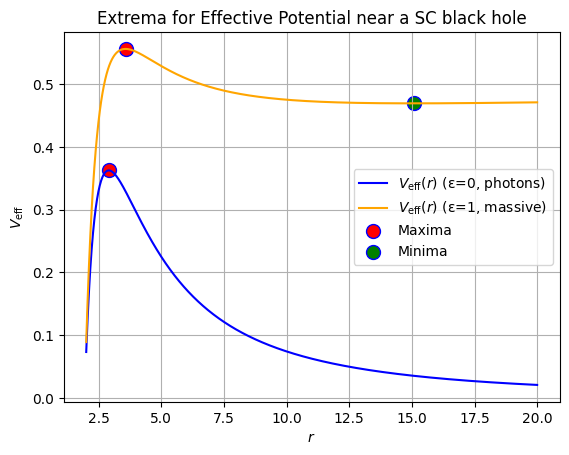

In [149]:
# Block 5 - locate extrema for v_eff vs r (radial distance from a black hole). 
# extrema are found using OGRePy 'nsolve' numerically.
def find_extrema_num(M_val, L_val, Q_b_val, Q_c_val, eps_val, r_range):
    v_eff = -0.5 * f(r, M_val, Q_b_val, Q_c_val) * (L_val**2 / h(r, M_val, Q_c_val) + eps_val)

    # first derivative with respect to r
    dv_eff_dr = gr.s.diff(v_eff, r)
    # second derivative with respect to r
    d2v_eff_dr2 = gr.s.diff(dv_eff_dr, r)

    extrema = []
    # solve dv_eff_dr = 0 for a range of initial guesses
    for r_init in np.linspace(r_range[0], r_range[1], 50):
        try:
            root = gr.s.nsolve(dv_eff_dr, r, r_init)
            root = float(root)
            if not any(np.isclose(root, ext, atol=1e-6) for ext in extrema) and r_range[0] <= root <= r_range[1]:
                extrema.append(root) # ensure no "very close" extrema (tolerance of 10^-6); only pick values within the chosen r range. 
        except Exception:
            pass  # skip guess if nsolve fails

    extrema_results = []
    print(f"\nExtrema for ε = {eps_val}:")
    for r_ex in extrema:
        v_eff_at_r = v_eff.subs(r, r_ex).evalf()  # v_eff value at extrema
        d2v_eff_dr2_r_ex = d2v_eff_dr2.subs(r, r_ex).evalf()  # 2nd derivative at extrema
        extrema_type = "min" if d2v_eff_dr2_r_ex > 0 else "max"
        extrema_results.append((r_ex, v_eff_at_r, extrema_type))
        print(f"r = {r_ex:.4f}, v_eff = {v_eff_at_r:.4f}, Type: {extrema_type}")

    return extrema_results, v_eff

r_range = (rs1, 10 * rs1)
eps0 = 0
eps1 = 1

# locate extrema for massless particles (epsilon = 0)
ext_photons, v_eff_photons = find_extrema_num(M1, L1, Q_b1, Q_c1, eps0, r_range)

# locate extrema for massive particles (epsilon = 1)
ext_timelike, v_eff_timelike = find_extrema_num(M1, L1, Q_b1, Q_c1, eps1, r_range)

r_vals1 = np.linspace(r_range[0], r_range[1], 1000)
v_eff_vals_photons = [v_eff_photons.subs(r, rv) for rv in r_vals1]
v_eff_vals_timelike = [v_eff_timelike.subs(r, rv) for rv in r_vals1]

# separate maxima, minima
max_x, max_y = [], []
min_x, min_y = [], []

for r_ex, v_eff_at_r, ext_type in ext_photons + ext_timelike:
    if ext_type == "max":
        max_x.append(r_ex)
        max_y.append(v_eff_at_r)
    else:
        min_x.append(r_ex)
        min_y.append(v_eff_at_r)

plt.plot(r_vals1, v_eff_vals_photons, color='b', label=r'$V_{\mathrm{eff}}(r)$ (ε=0, photons)')
plt.plot(r_vals1, v_eff_vals_timelike, color='orange', label=r'$V_{\mathrm{eff}}(r)$ (ε=1, massive)')
plt.scatter(max_x, max_y, color='r', s=100, edgecolors='b', label="Maxima")
plt.scatter(min_x, min_y, color='g', s=100, edgecolors='b', label="Minima")
plt.xlabel(r'$r$')
plt.ylabel(r'$V_{\mathrm{eff}}$')
plt.title("Extrema for Effective Potential near a SC black hole")
plt.legend()
plt.grid(True)
plt.show()

Extrema for epsilon=0:
r = 2.9009, v_eff = 0.3626

Extrema for epsilon=1:
r = 3.5676, v_eff = 0.5562
r = 15.0811, v_eff = 0.4695


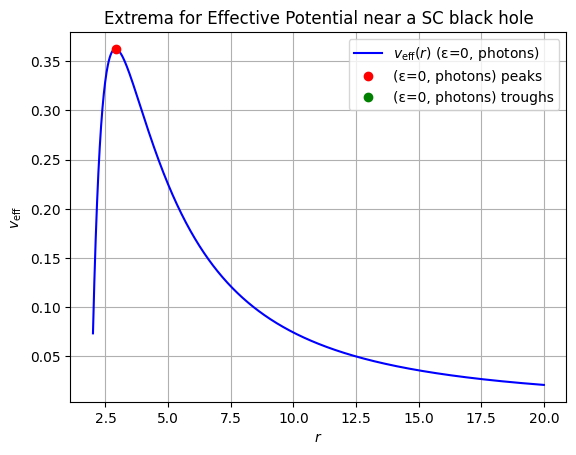

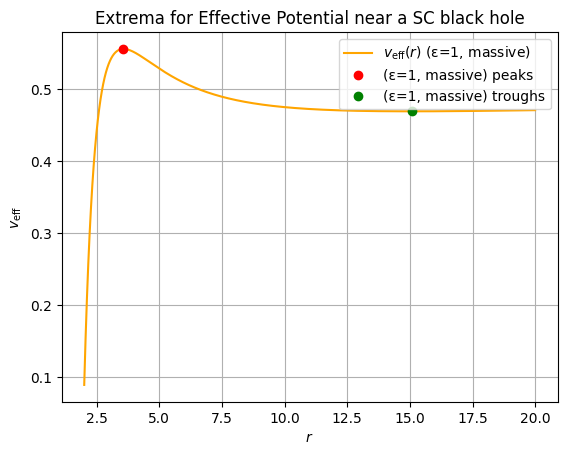

In [150]:
# block 6 - find extrema for v_eff vs r for the space around a black hole in a quantum-corrected Schwarzschild metric.
# solved numerically using scipy "find_peaks"...borrowed from signal processing.

from scipy.signal import find_peaks

# find peaks for sigma=0, sigma=1
peaks1, _ = find_peaks(v_eff_vals_Q1)
peaks2, _ = find_peaks(v_eff_vals_Q1_1)

# detect troughs (invert the function to find minima as peaks) for epsilon=0, epsilon=1
troughs1, _ = find_peaks(-v_eff_vals_Q1)
troughs2, _ = find_peaks(-v_eff_vals_Q1_1)

# combine and sort extrema
extrema1 = np.sort(np.concatenate((peaks1, troughs1)))
extrema2 = np.sort(np.concatenate((peaks2, troughs2)))

# print extrema values for epsilon=0 and epsilon=1
print("Extrema for epsilon=0:")
for j in extrema1:
    print(f"r = {r_vals[j]:.4f}, v_eff = {v_eff_vals_Q1[j]:.4f}")

print("\nExtrema for epsilon=1:")
for k in extrema2:
    print(f"r = {r_vals[k]:.4f}, v_eff = {v_eff_vals_Q1_1[k]:.4f}")

plt.plot(r_vals, v_eff_vals_Q1, color='b', label=r'$v_{\mathrm{eff}}(r)$ (ε=0, photons)')
plt.plot(r_vals[peaks1], v_eff_vals_Q1[peaks1], 'o', color='r', label='(ε=0, photons) peaks')
plt.plot(r_vals[troughs1], v_eff_vals_Q1[troughs1], 'o', color='g', label='(ε=0, photons) troughs')
plt.xlabel(r'$r$')
plt.ylabel(r'$v_{\rm eff}$')
plt.title('Extrema for Effective Potential near a SC black hole')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(r_vals, v_eff_vals_Q1_1, color='orange', label=r'$v_{\mathrm{eff}}(r)$ (ε=1, massive)')
plt.plot(r_vals[peaks2], v_eff_vals_Q1_1[peaks2], 'o', color='r', label='(ε=1, massive) peaks')
plt.plot(r_vals[troughs2], v_eff_vals_Q1_1[troughs2], 'o', color='g', label='(ε=1, massive) troughs')
plt.xlabel(r'$r$')
plt.ylabel(r'$v_{\rm eff}$')
plt.title('Extrema for Effective Potential near a SC black hole')
plt.legend()
plt.grid(True)
plt.show()

# Orbits

In this approach we solve for $r(\lambda)$ and $\phi(\lambda)$ by integrating the equations of motion $\frac{dr}{d\lambda}$ and $\frac{d\phi}{d\lambda}$ with 'solve_ivp', then make a polar plot $r(\lambda)$ vs $\phi(\lambda)$ and convert to cartesian coordinates to plot y(x).

In the following code block we define the solver function, 'solve_r_phi_lamda', then in the next block we set initial conditions, run the solver, and plot. We can test starting the particle far away from the black hole and moving it inwards; or start relatively close in and move outwards. Next steps will be to change initial conditions to reproduce a circular, scattering and plunge orbit.

In [153]:
# block 7 - solver to compute r(lambda), phi(lambda)

# solve for r and phi as a function of tau using eq_of_motion
def solve_r_phi_lamda(params, lamda_range, r_init, phi_init, epsilon=0):

    E, L, M, Q_b, Q_c = params

    # initial conditions [t, r, phi]
    y0 = [0, r_init, phi_init] 

    def dy_dt(lamda, y):
        # get ODE's from eq_of_motion function
        dt_dlamda, dr_dlamda, dphi_dlamda = eq_of_motion(lamda, y, params, epsilon)
        
        return [dt_dlamda, dr_dlamda, dphi_dlamda]

    # solve for r(lambda) and phi(lambda)
    sol = solve_ivp(dy_dt, lamda_range, y0, t_eval=np.linspace(*lamda_range, 5000), atol=1e-6, rtol=1e-6)
    return sol


Initial dr/dlambda: 0.519168830753093


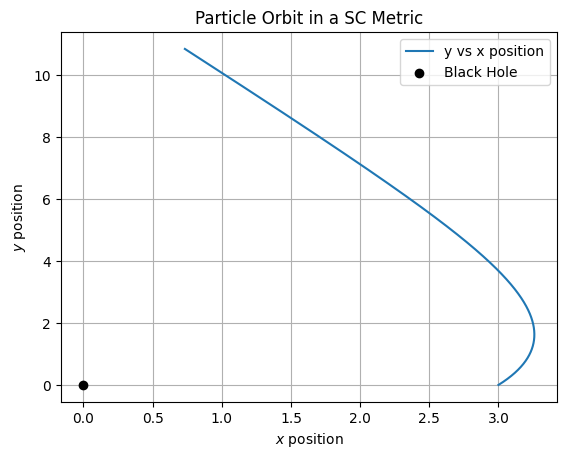

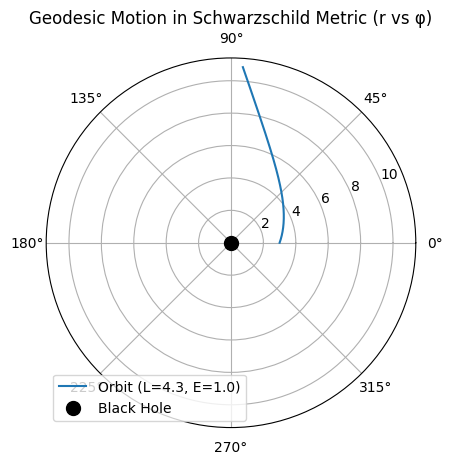

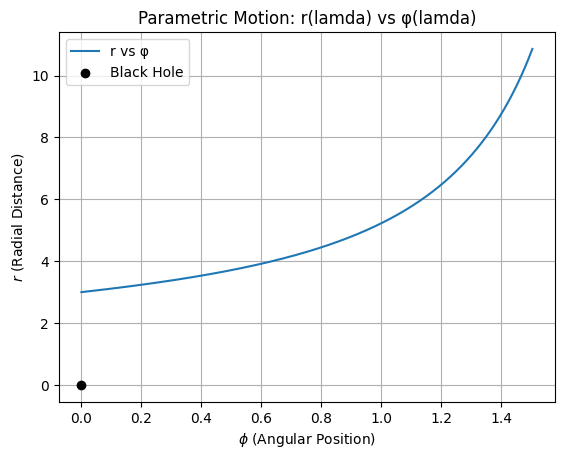

In [154]:
# block 8 
# initial conditions / constants
r_init1 = 1.5 * rs1
params1 = [E1, L1, M1, Q_b1, Q_c1]

# **** final lamda value is (+) if going away from BH; (-) if going towards the BH ****
lamda_range1 = [0, 10]
#lamda_range1 = [0, -10]
phi_init1 = 0

# **** test to check sign of initial dr/d_lamda value ****
dt0, dr0, dphi0 = eq_of_motion(0, [0, r_init1, phi_init1], params1, epsilon=0)
print(f"Initial dr/dlambda: {dr0}") 

sol_y = solve_r_phi_lamda(params1, lamda_range1, r_init1, phi_init1, epsilon=0)

if not sol_y.success:
    print("Integration failed:", sol_y.message)

# get results for r(lamda) and phi(lamda)
r_vals1 = sol_y.y[1]  # radial distances
phi_vals1 = sol_y.y[2]  # angular positions

x1 = r_vals1 * np.cos(phi_vals1)
y1 = r_vals1 * np.sin(phi_vals1)
 
# cartesian coordinates
plt.plot(x1, y1, label=f'y vs x position')
plt.scatter([0], [0], color='black', label='Black Hole', zorder=5)
plt.xlabel(r'$x$ position')
plt.ylabel(r'$y$ position')
plt.title('Particle Orbit in a SC Metric')
plt.legend()
plt.grid(True)
plt.show()

# polar plot
plt.polar(phi_vals1, r_vals1, label=f'Orbit (L={L1}, E={E1})')
plt.scatter([0], [0], color='black', marker='o', s=100, label='Black Hole', zorder=5)
plt.title('Geodesic Motion in Schwarzschild Metric (r vs φ)')
plt.legend()
plt.grid(True)
plt.show()

# parametric plot: r(lamda) vs phi(lamda)
plt.plot(phi_vals1, r_vals1, label=f'r vs φ')
plt.scatter([0], [0], color='black', label='Black Hole', zorder=5)
plt.xlabel(r'$\phi$ (Angular Position)')
plt.ylabel(r'$r$ (Radial Distance)')
plt.title('Parametric Motion: r(lamda) vs φ(lamda)')
plt.legend()
plt.grid(True)
plt.show()

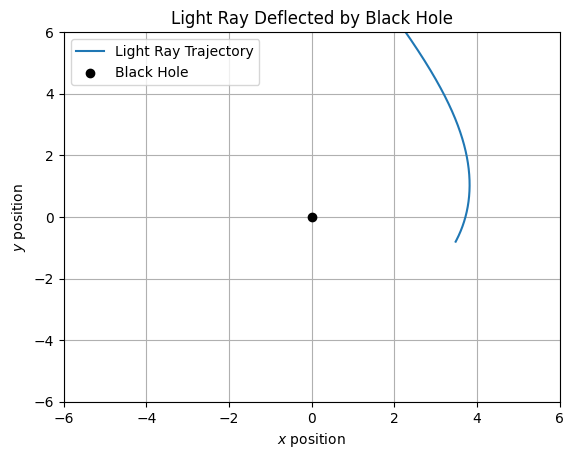

In [156]:
# block 8B - light ray orbits
# orbits starting at infinity
 
# initial conditions
r_init4 = 5 * rs1
phi_init4 = 0.5 * np.pi

# Adjust angular momentum for a scattering trajectory
L_scattering = np.sqrt(27) * E1 * M1 + 0.05  # > sqrt(27) * E1 * M1 ensures scattering
params4 = [E1, L_scattering, M1, Q_b0, Q_c0]

lamda_range4 = [0, -10]

# Solve for the trajectory
sol_y4 = solve_r_phi_lamda(params4, lamda_range4, r_init4, phi_init4, epsilon=0)

if not sol_y4.success:
    print("Integration failed:", sol_y4.message)

# extract radial and angular positions
r_vals4 = sol_y4.y[1]
phi_vals4 = sol_y4.y[2]
lamda_vals4 = sol_y4.t

# cartesian coordinates
x4 = r_vals4 * np.cos(phi_vals4)
y4 = r_vals4 * np.sin(phi_vals4)

plt.plot(x4, y4, label='Light Ray Trajectory')
plt.scatter([0], [0], color='black', label='Black Hole', zorder=5)
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel(r'$x$ position')
plt.ylabel(r'$y$ position')
plt.title('Light Ray Deflected by Black Hole')
plt.legend()
plt.grid(True)
plt.show()

# Orbits - method 2

In the 2nd approach we find $r(\phi)$ using the following expression,

$$\frac{dr}{d\phi} = \frac{\dot{r}}{\dot{\phi}} = \frac{h(r)}{L} \sqrt{-\frac{1}{g(r)} \left( \frac{E^2}{f(r)} + \left( \epsilon +\frac{L^2}{h(r)} \right) \right)}$$

then integrate using 'solve_ivp' and plot in polar format. In the next code block we define a solver named 'solve_r_phi' then in the following code block we set initial conditions, run the solver, and plot the orbit.

In [157]:
# block 9 - (need new version of dr_dphi) solve for r(phi) and make a polar plot
# define dr/dphi solver function for integration
def solve_r_phi(params, phi_range, r_init, epsilon=0):
    
    E, L, M, Q_b, Q_c, r_max = params  # unpack parameters
    
    def dr_dphi(phi, y):
        r = y[0]
        corr = 1e-6
        
        # stop integration if r is out of bounds
        if r <= rs1 + corr or r >= r_max:
            return [0] 
        
        hh = h(r, M, Q_c)
        ff = f(r, M, Q_b, Q_c)
        gg = g(r, M, Q_b, Q_c)
        dr_dphi = (hh / L) * gr.s.sqrt(max(0, -1 / gg * (E**2 / ff + (L**2 / hh + epsilon))))
        return [dr_dphi]
    
    # Solve the ODE
    sol = solve_ivp(dr_dphi, phi_range, [r_init], t_eval=np.linspace(*phi_range, 1000), atol=1e-5, rtol=1e-5)
    return sol

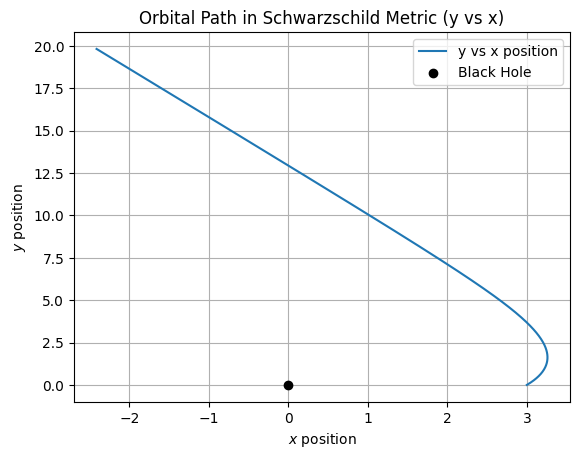

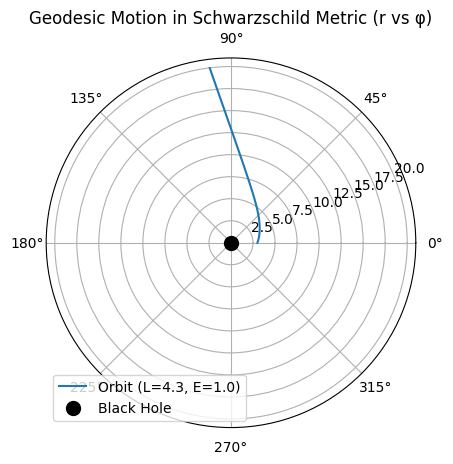

In [158]:
# Block 10
# code to integrate dr_dphi and display as a polar plot and cartesian plot

# initial conditions
phi_range2 = (0, 2 * np.pi)
r_init2 = 1.5 * rs1
r_max2 = 10 * rs1
params2 = [E1, L1, M1, Q_b1, Q_c1, r_max2]
sol_r_phi = solve_r_phi(params2, phi_range2, r_init2)

# extract solution
phi_vals2 = sol_r_phi.t
r_vals2 = sol_r_phi.y[0]
valid_indices = r_vals2 <= r_max2
phi_vals3 = phi_vals2[valid_indices]
r_vals3 = r_vals2[valid_indices]

# convert to cartesian coords
x2 = r_vals3 * np.cos(phi_vals3)
y2 = r_vals3 * np.sin(phi_vals3)
 
# cartesian coordinates
plt.plot(x2, y2, label=f'y vs x position')
plt.scatter([0], [0], color='black', label='Black Hole', zorder=5)
plt.xlabel(r'$x$ position')
plt.ylabel(r'$y$ position')
plt.title('Orbital Path in Schwarzschild Metric (y vs x)')
plt.legend()
plt.grid(True)
plt.show()

# plar plot
plt.polar(phi_vals3, r_vals3, label=f'Orbit (L={L1}, E={E1})')
plt.scatter([0], [0], color='black', marker='o', s=100, label='Black Hole', zorder=5)
plt.title('Geodesic Motion in Schwarzschild Metric (r vs φ)')
plt.legend()
plt.grid(True)
plt.show()